In [2]:
# import stuff
import os, sys, time
import tifffile as tif
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv

In [17]:
# for a given csv file, read in as a pandas df
def csv_to_pd(filename):
    fn=[]
    with open(filename) as csvfile:
        reader = csv.reader(csvfile,delimiter=',')
        for row in reader:
            fn.append(row)
    fnd = pd.DataFrame(fn)
    return fnd

In [38]:
#for a column in a df, replace spaces with _ and make all lowercase
def make_column_safe(df,num):
    for idx in df.index:
        strfx = df[num][idx]
        strfx = strfx.replace(' ','_').lower()
        df[num][idx] = strfx
    return df

In [39]:
# this will mean I need to make sure same labels are same across all files
# but I might need to make each file separate

In [52]:
whs = csv_to_pd("/Users/emilydennis/Desktop/today/WHS_labels.csv")
whs = make_column_safe(whs,2)

In [53]:
ann = tif.imread('/Users/emilydennis/Desktop/today/WHS_ann_in_mPRA.tif')
mpramask = tif.imread('/Users/emilydennis/Desktop/today/mPRA-mask.tif')

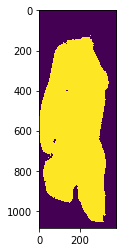

In [59]:
[xmax,ymax,zmax] = np.shape(mpramask)
x=400
for y in arange(0,ymax):
    for z in arange(0,zmax):
        if ann[400,x,y] > 0:
            